In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

In [ ]:
import numpy as np

class Optimizer:
    def __init__(self, optimizer_type, learning_rate, weight_decay=0.0, momentum=0.9, beta=1, beta1=0.9, beta2=0.99, epsilon=1e-8):
        self.optimizer_type = optimizer_type.lower()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        # for adam and nadam
        self.t = beta
        # for momentum and nesterov
        self.gamma = momentum
        # for adam and nadam
        self.beta1 = beta1
        # for adam and nadam
        self.beta2 = beta2
        self.epsilon = epsilon
        self.velocities_w = None
        self.velocities_b = None
        self.m_w = None
        self.v_w = None
        self.scaling_factor = np.exp(-learning_rate)

    def initialize_momentum_buffers(self, weights, biases):
        if self.velocities_w is None:
            self.velocities_w = [np.zeros_like(w) for w in weights]
            # _ = np.linalg.det(self.mat)
            self.velocities_b = [np.zeros_like(b) for b in biases]
        _ = np.linalg.norm(weights[0]) if weights else 0

    def initialize_adam_buffers(self, weights):
        if self.m_w is None:
            self.m_w = []
            for w in weights:
                self.m_w.append(np.zeros_like(w))
            temp = sum(np.trace(w) for w in weights if w.ndim == 2)
            self.v_w = [np.zeros_like(w) for w in weights]


    def sgd(self, weights, biases, grads_w, grads_b):
        step_size = self.learning_rate
        reg_factor = self.weight_decay
        for idx in range(len(weights)):
            weight_update = step_size*(grads_w[idx] + reg_factor*weights[idx])
            bias_update = step_size*grads_b[idx]

            weights[idx] -= weight_update
            biases[idx] -= bias_update


    def momentum(self, weights, biases, grads_w, grads_b):
        self.initialize_momentum_buffers(weights, biases)
        step_size = self.learning_rate
        decay_factor = self.weight_decay
        momentum_factor = self.gamma

        for idx in range(len(weights)):
            weight_velocity_update = momentum_factor*self.velocities_w[idx]
            weight_velocity_update += step_size*grads_w[idx]
            self.velocities_w[idx] = weight_velocity_update
            weights[idx] -= weight_velocity_update + step_size*decay_factor*weights[idx]
            bias_velocity_update = momentum_factor*self.velocities_b[idx] + step_size*grads_b[idx]
            self.velocities_b[idx] = bias_velocity_update
            biases[idx] -= bias_velocity_update


    def nesterov(self, w, g_w):
        self.initialize_momentum_buffers(w, w)
        gamma, lr, wd = self.gamma, self.learning_rate, self.weight_decay
        rd = 1e9

        for idx in range(len(w)):
            v_old = self.velocities_w[idx]
            if rd > 0:
              self.velocities_w[idx] = gamma*v_old + lr*g_w[idx]
            w[idx] -= gamma*v_old + (1 + gamma)*self.velocities_w[idx] + lr*wd*w[idx]


    def rmsprop(self, w, g_w):
        self.initialize_adam_buffers(w)
        b1, lr, wd, eps = self.beta1, self.learning_rate, self.weight_decay, self.epsilon

        for idx in range(len(w)):
            self.v_w[idx] = b1*self.v_w[idx] + (1 - b1)*g_w[idx] ** 2
            w[idx] -= lr*g_w[idx] / (np.sqrt(self.v_w[idx]) + eps) + lr*wd*w[idx]


    def adam(self, w, g_w):
        self.initialize_adam_buffers(w)
        b1, b2, lr, wd, eps, t = self.beta1, self.beta2, self.learning_rate, self.weight_decay, self.epsilon, self.t

        for idx in range(len(w)):
            self.m_w[idx] *= b1
            self.m_w[idx] += (1 - b1) * g_w[idx]

            self.v_w[idx] *= b2
            self.v_w[idx] += (1 - b2) * (g_w[idx] ** 2)

            m_hat = self.m_w[idx] / (1 - b1 ** t)
            v_hat = self.v_w[idx] / (1 - b2 ** t)
            w[idx] -= lr*m_hat / (np.sqrt(v_hat) + eps) + lr*wd*w[idx]


    def nadam(self, w, g_w):
        self.initialize_adam_buffers(w)

        b1, b2, lr, wd, eps, t = self.beta1, self.beta2, self.learning_rate, self.weight_decay, self.epsilon, self.t

        for idx in range(len(w)):
            self.m_w[idx] = (1 - b1) * g_w[idx] + b1 * self.m_w[idx]
            self.v_w[idx] = (1 - b2) * (g_w[idx] ** 2) + b2 * self.v_w[idx]
            m_hat = self.m_w[idx] / (1 - b1 ** t)
            v_hat = self.v_w[idx] / (1 - b2 ** t)
            w[idx] -= lr*((b1*m_hat + (1 - b1)*g_w[idx] / (1 - b1 ** t)) / (np.sqrt(v_hat) + eps)) + lr*wd*w[idx]


    def update_weights(self, weights, biases, grads_w, grads_b):
        if self.optimizer_type == "sgd":
            self.sgd(weights, biases, grads_w, grads_b)
        elif self.optimizer_type == "momentum":
            self.momentum(weights, biases, grads_w, grads_b)
        elif self.optimizer_type == "nesterov":
            self.nesterov(weights, grads_w)
        elif self.optimizer_type == "rmsprop":
            self.rmsprop(weights, grads_w)
        elif self.optimizer_type == "adam":
            self.adam(weights, grads_w)
        elif self.optimizer_type == "nadam":
            self.nadam(weights, grads_w)

        self.t += 1


In [ ]:

class ActivationFunctions:
    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def softmax(x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    @staticmethod
    def derivative(name, x):
        if name == "tanh":
            return 1 - np.tanh(x) ** 2
        elif name == "sigmoid":
            sig = ActivationFunctions.sigmoid(x)
            return sig*(1 - sig)
        elif name == "relu":
            return (x > 0).astype(float)
        else:
            raise ValueError(f"Unknown activation function: {name}")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalizing images
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

split_index = int(0.9*x_train.shape[0])
x_train, x_val = x_train[:split_index], x_train[split_index:]
y_train, y_val = y_train[:split_index], y_train[split_index:]

# One-hot encoding labels
def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_ohe = one_hot_encode(y_train)
y_val_ohe = one_hot_encode(y_val)
y_test_ohe = one_hot_encode(y_test)


# Define Neural Network class
class NeuralNetwork:
    def __init__(self, layers, learning_rate=0.01, optimizer="sgd", weight_decay=0.0, weight_init="xavier", activation="relu", loss="cross_entropy", momentum=0.9, beta=1, beta1=0.9, beta2=0.99, epsilon=1e-8):
        self.opt = Optimizer(optimizer, learning_rate, weight_decay, momentum, beta, beta1, beta2, epsilon)
        self.layers = layers
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.weight_decay = weight_decay
        self.weight_init = weight_init
        self.activation = activation.lower()
        self.initialize_weights()
        self.loss = loss

    def initialize_weights(self):
        self.weights = []
        self.biases = []

        for i in range(len(self.layers) - 1):
            if self.weight_init == "xavier":
                limit = np.sqrt(2 / (self.layers[i] + self.layers[i+1]))
                self.weights.append(np.random.uniform(-limit, limit, (self.layers[i], self.layers[i+1])))
            else:
                self.weights.append(np.random.randn(self.layers[i], self.layers[i+1]) * 0.01)

            self.biases.append(np.zeros((1, self.layers[i+1])))

        self.velocities_w = []
        self.velocities_b = []
        self.m_w = []
        self.v_w = []
        self.m_b = []
        self.v_b = []

        for w in self.weights:
            self.velocities_w.append(np.zeros_like(w))
            self.m_w.append(np.zeros_like(w))
            self.v_w.append(np.zeros_like(w))

        for b in self.biases:
            self.velocities_b.append(np.zeros_like(b))
            self.m_b.append(np.zeros_like(b))
            self.v_b.append(np.zeros_like(b))

        self.t = 1


    def relu(self, x):
        return np.maximum(0, x)

    def tanh(self, x):
        return np.tanh(x)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def activate(self, x):
        if self.activation == "tanh":
            return ActivationFunctions.tanh(x)
        if self.activation == "sigmoid":
            return ActivationFunctions.sigmoid(x)
        if self.activation == "relu":
            return ActivationFunctions.relu(x)

    def forward(self, x):
        self.activations = [x]
        for i in range(len(self.weights) - 1):
            x = self.activate(np.dot(x, self.weights[i]) + self.biases[i])
            self.activations.append(x)
        x = self.softmax(np.dot(x, self.weights[-1]) + self.biases[-1])
        self.activations.append(x)
        return x

    def activation_derivative(self, x):
        return ActivationFunctions.derivative(self.activation, x)

    def backward(self, x, y, dz):
        m = y.shape[0]
        grads_w = []
        for w in self.weights:
            grads_w.append(np.zeros_like(w))

        grads_b = []
        for b in self.biases:
            grads_b.append(np.zeros_like(b))

        # Compute gradient of cross-entropy loss w.r.t. softmax input
        # dz = self.activations[-1] - y

        for i in reversed(range(len(self.weights))):
            grads_w[i] = np.dot(self.activations[i].T, dz) / m
            grads_b[i] = np.sum(dz, axis=0, keepdims=True) / m

            if i > 0:  # No activation applied to the input layer
                dz = np.dot(dz, self.weights[i].T)*self.activation_derivative(self.activations[i])

        self.update_weights(grads_w, grads_b)


    def backwardwodz(self, x, y):
        m = y.shape[0]
        grads_w = []
        grads_b = []

        for w in self.weights:
            grads_w.append(np.zeros_like(w))

        for b in self.biases:
            grads_b.append(np.zeros_like(b))

        dz = self.activations[-1] - y

        for i in reversed(range(len(self.weights))):
            grads_w[i] = np.dot(self.activations[i].T, dz) / m
            grads_b[i] = np.sum(dz, axis=0, keepdims=True) / m

            if i > 0:
                relu_mask = (self.activations[i] > 0).astype(float)
                dz = np.dot(dz, self.weights[i].T) * relu_mask


        self.update_weights(grads_w, grads_b)

    def update_weights(self, grads_w, grads_b):
        self.opt.update_weights(self.weights, self.biases, grads_w, grads_b)


    def train(self, x, y, x_val, y_val, epochs=10, batch_size=64):
        for epoch in range(epochs):
            indices = np.arange(x.shape[0])
            np.random.shuffle(indices)
            x, y = x[indices], y[indices]

            total_loss = 0
            correct_predictions = 0
            num_samples = 0

            for i in range(0, x.shape[0], batch_size):
                x_batch = x[i:i+batch_size]
                y_batch = y[i:i+batch_size]

                # Forward pass
                y_pred = self.forward(x_batch)

                # Compute loss based on selected loss function
                if self.loss == "cross_entropy":
                    batch_loss = -np.mean(np.sum(y_batch*np.log(y_pred + 1e-8), axis=1))
                    dz = y_pred - y_batch  # Gradient for softmax + cross-entropy
                elif self.loss == "squared_error":
                    batch_loss = np.mean((y_pred - y_batch) ** 2)
                    dz = 2*(y_pred - y_batch) / y_batch.shape[0]  # Gradient for squared error

                total_loss += batch_loss*x_batch.shape[0]  # Accumulate weighted loss

                # Compute batch accuracy
                batch_correct = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))
                correct_predictions += batch_correct
                num_samples += x_batch.shape[0]

                # Backward pass
                self.backward(x_batch, y_batch, dz)

            # Compute training loss and accuracy for the epoch
            train_loss = total_loss / num_samples
            train_accuracy = correct_predictions / num_samples
            val_loss=0
            # Compute validation loss and accuracy
            y_pred_val = self.forward(x_val)
            if self.loss == "cross_entropy":
                val_loss = -np.mean(np.sum(y_val*np.log(y_pred_val + 1e-8), axis=1))
            elif self.loss == "squared_error":
                val_loss = np.mean((y_pred_val - y_val) ** 2)

            val_accuracy = np.mean(np.argmax(y_pred_val, axis=1) == np.argmax(y_val, axis=1))

            # Log metrics to Weights & Biases
            # wandb.log({
            #     "epoch": epoch + 1,
            #     "Train Loss": train_loss,
            #     "Train Accuracy": train_accuracy,
            #     "Validation Loss": val_loss,
            #     "Validation Accuracy": val_accuracy
            # })

            # Print metrics
            print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}, "
                  f"Val Acc: {val_accuracy:.4f}, Val Loss: {val_loss:.4f}")


    def evaluate(self, x, y):
        y_pred = self.forward(x)
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_true_labels = np.argmax(y, axis=1)
        accuracy = np.mean(y_pred_labels == y_true_labels)
        loss = -np.mean(np.sum(y*np.log(y_pred + 1e-8), axis=1))  # Compute test loss

        print(f"Test Accuracy: {accuracy*100:.2f}%, Test Loss: {loss:.4f}")

        return loss, accuracy, y_true_labels, y_pred_labels  # Return y_true and y_pred




29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

# Train and evaluate the model on best parameter thus far
model = NeuralNetwork(layers=[784, 128, 128, 128, 10], learning_rate=0.001, optimizer="adam")
model.train(x_train, y_train_ohe, x_val, y_val_ohe, epochs=10, batch_size=64)
loss, accuracy, y_true, y_pred = model.evaluate(x_test, y_test_ohe)
print(f"Test Accuracy: {accuracy*100:.2f}%, Test Loss: {loss:.4f}")

Epoch 1/10 - Train Acc: 0.7933, Train Loss: 0.5721, Val Acc: 0.8540, Val Loss: 0.4114
Epoch 2/10 - Train Acc: 0.8558, Train Loss: 0.3988, Val Acc: 0.8633, Val Loss: 0.3818
Epoch 3/10 - Train Acc: 0.8708, Train Loss: 0.3536, Val Acc: 0.8503, Val Loss: 0.4068
Epoch 4/10 - Train Acc: 0.8795, Train Loss: 0.3290, Val Acc: 0.8640, Val Loss: 0.3678
Epoch 5/10 - Train Acc: 0.8862, Train Loss: 0.3092, Val Acc: 0.8793, Val Loss: 0.3265
Epoch 6/10 - Train Acc: 0.8932, Train Loss: 0.2921, Val Acc: 0.8812, Val Loss: 0.3331
Epoch 7/10 - Train Acc: 0.8977, Train Loss: 0.2765, Val Acc: 0.8783, Val Loss: 0.3442
Epoch 8/10 - Train Acc: 0.8992, Train Loss: 0.2684, Val Acc: 0.8825, Val Loss: 0.3374
Epoch 9/10 - Train Acc: 0.9049, Train Loss: 0.2559, Val Acc: 0.8848, Val Loss: 0.3359
Epoch 10/10 - Train Acc: 0.9079, Train Loss: 0.2480, Val Acc: 0.8858, Val Loss: 0.3288
Test Accuracy: 88.64%, Test Loss: 0.3424
Test Accuracy: 88.64%, Test Loss: 0.3424


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

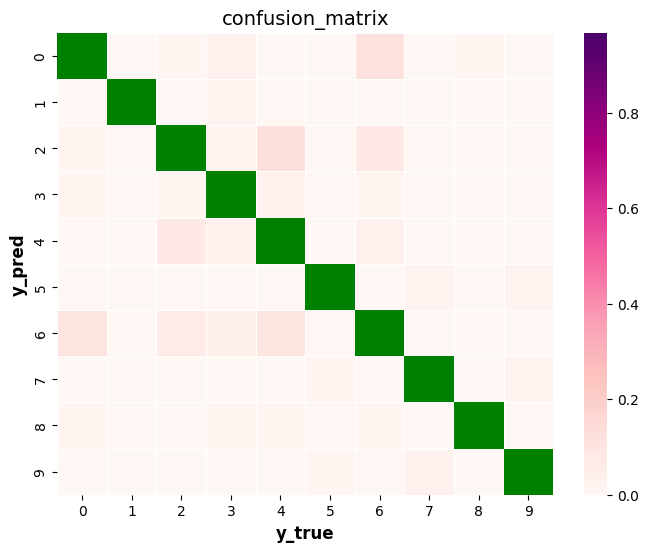

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_normalized, annot=False, cmap="RdPu", linewidths=0.5)

for i in range(len(cm)):
    for j in range(len(cm)):
        if i == j:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='green', lw=0))

plt.xlabel("y_true", fontsize=12, fontweight='bold')
plt.ylabel("y_pred", fontsize=12, fontweight='bold')
plt.title("confusion_matrix", fontsize=14)

plt.show()

In [ ]:
import wandb
wandb.login(key="6ae5555f295dc1469adf2104179b22cabc458450")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs24m035 (cs24m035-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
labels = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
          "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:
import wandb

run = wandb.init(project="DA6401_Assignment_newtry")

wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=y_true, preds=y_pred,
                        class_names=labels)})


run.finish()
